In [157]:
!pip install tifffile
!pip install rasterio

In [0]:
import sys
import os
import json 

from google.colab import drive

import numpy as np
import pandas as pd

from skimage.transform import resize
from skimage.color import rgb2gray

import matplotlib
import matplotlib.pyplot as plt

from sklearn import cluster
from sklearn.svm import SVC
from sklearn import preprocessing

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

from sklearn.utils import shuffle

In [159]:
drive.mount('/content/drive')

directory = '/content/drive/My Drive/shipsnet'
kaggle = directory + '/shipsnet.json'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#S1:
Check the description, data, activities and scripts. HW4 will use the "Ships" dataset. Download the data to your PC/laptop (data size 434 MB). The data is kept in .json format and reading it in Python is pretty straightforward. See example notebooks.

- Q1: What is the number of images in this dataset: **4000**
- Q2: What is the number of different labels in this dataset: **2**
- Q3: What is the size of each image in this dataset: **80 x 80 x 3 bands**

In [160]:
with open(kaggle) as ships:
    shipsnet = json.load(ships)

df = pd.DataFrame(shipsnet)
df.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [161]:
y = np.asarray(shipsnet['labels'])
X = np.asarray(shipsnet['data']).astype('uint8')

print(y.shape)
print(X.shape)

(4000,)
(4000, 19200)



#S2:
Select all "ship" images, convert 3-channel (RGB) images to single-channel (Gray) (hint: scikit has the function "rgb2gray"). Flatten the images into a data matrix and apply PCA on them. Display the first 4 principal components as 2D images.

- Q1: What is the number of "ship" images: **1000**
- Q2: What is the total variance explained by the first 5 PCA components: **0.7333**
- Q3: How many PCA components are required to explain at least 50% of the variance: **just two components!**

In [162]:
reshaped = X.reshape([4000, 3, 80, 80])
reaxised = np.moveaxis(reshaped, 1, 3)

bnw = rgb2gray(reaxised)
col = reaxised
dat = bnw.reshape([4000, 6400])

print(bnw.shape)
print(col.shape)
print(dat.shape)

(4000, 80, 80)
(4000, 80, 80, 3)
(4000, 6400)


I will start by plotting a sample to get a feel for this format and to check the shape of the data.

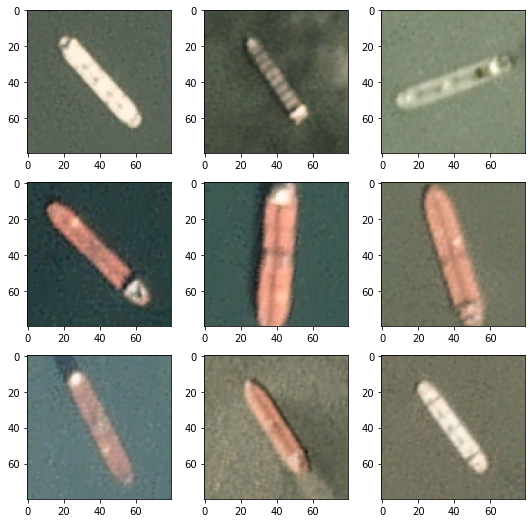

In [163]:
fig, axs = plt.subplots(3, 3, figsize = [9, 9])

for i in np.arange(0, 3):
    for j in np.arange(0, 3):
        idx = i*5+j
        cImg = col[idx]
        axs[i, j].imshow(cImg)
        
plt.show()

Now, I will plot the greyscale version of the same images to make sure that that worked.

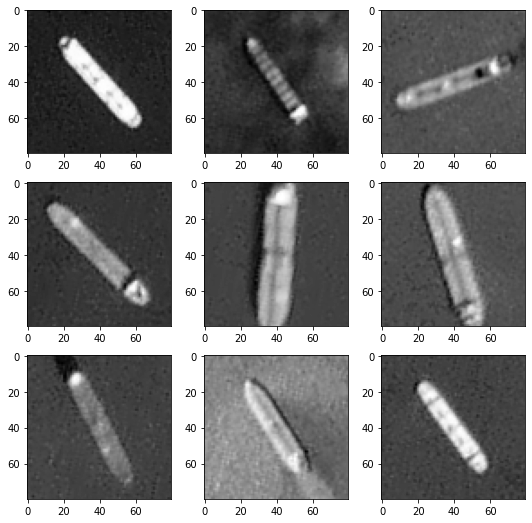

In [164]:
fig, axs = plt.subplots(3, 3, figsize = [9, 9])

for i in np.arange(0, 3):
    for j in np.arange(0, 3):
        idx = i*5+j
        gImg = bnw[idx]
        axs[i, j].imshow(gImg, cmap = 'gray')
        
plt.show()

Next, I will take a random selection just to see if everything is as it should be, with flattened images that can be reshaped into the original tile.

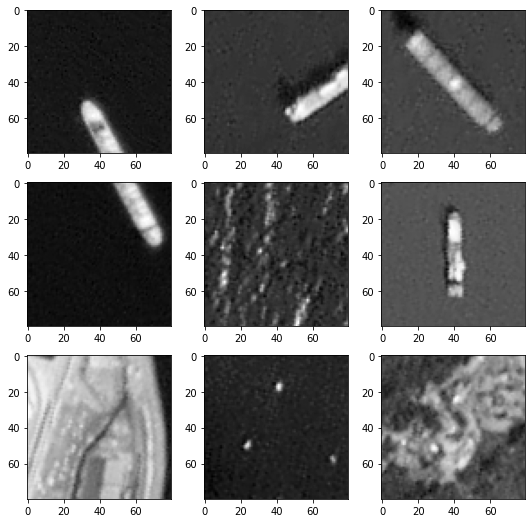

In [165]:
sel = np.random.randint(0, 4000, 9)

fig, axs = plt.subplots(3, 3, figsize = [9, 9])

for i in np.arange(0, 3):
    for j in np.arange(0, 3):
        idx = i*3+j
        gImg = dat[sel[idx]].reshape([80, 80])
        axs[i, j].imshow(gImg, cmap = 'gray')
        
plt.show()

In [166]:
print(len(y[y == 1]))

1000


In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [0]:
NUM_COMP = 80

In [0]:
mat = dat[y == 1]

scaler = StandardScaler()
scaler.fit(mat)
X = scaler.transform(mat)

In [170]:
pca = PCA(n_components = NUM_COMP)
pcaMdl = pca.fit(X)
pcaCoor = pcaMdl.transform(X)
dfPCA = pd.DataFrame(data = pcaCoor, columns = ['PCA_' + s for s in np.arange(0, NUM_COMP).astype(str)])

dfPCA.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22,PCA_23,PCA_24,PCA_25,PCA_26,PCA_27,PCA_28,PCA_29,PCA_30,PCA_31,PCA_32,PCA_33,PCA_34,PCA_35,PCA_36,PCA_37,PCA_38,PCA_39,PCA_40,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49,PCA_50,PCA_51,PCA_52,PCA_53,PCA_54,PCA_55,PCA_56,PCA_57,PCA_58,PCA_59,PCA_60,PCA_61,PCA_62,PCA_63,PCA_64,PCA_65,PCA_66,PCA_67,PCA_68,PCA_69,PCA_70,PCA_71,PCA_72,PCA_73,PCA_74,PCA_75,PCA_76,PCA_77,PCA_78,PCA_79
0,-14.077932,-16.978053,-33.529743,11.573296,18.720670,11.260411,9.582690,-8.038178,-9.054114,5.382610,-7.420555,10.487580,-8.769588,-6.030578,-1.769539,1.805166,8.260207,5.631623,-1.275234,7.402271,2.916972,-0.018773,-5.499016,2.538272,0.130326,-1.319506,-2.721540,-1.712964,2.128888,-1.765806,-4.857700,1.257367,-0.739300,-1.161746,-2.758035,-0.795172,-1.731391,-0.268364,-2.369534,1.012094,0.583371,-2.916463,0.742669,-1.493044,-0.735473,-0.601924,0.719971,-0.187563,-1.494015,-0.341844,2.019783,-1.243596,-1.083234,-0.623859,-1.266408,0.921412,0.012216,1.032147,0.840386,0.947371,-0.529968,0.311020,2.780525,0.000146,0.224321,-1.981010,-0.280915,0.584880,-0.780734,0.411475,-0.625878,-0.645411,-2.143284,-1.271006,-0.300677,1.354699,1.239909,-0.412253,0.632735,0.859117
1,32.017468,10.177297,-12.653708,-12.580257,-8.679751,-16.532534,3.406943,1.826551,-11.611023,12.233846,-2.870245,4.141836,-4.877332,0.797240,-3.775325,2.186594,1.879907,2.060122,-8.775890,-7.939076,-0.443255,-5.282828,0.422824,-1.702424,3.327992,2.008495,-0.708199,-0.237263,-0.360949,-2.331241,-2.526880,-7.028479,4.178047,7.107064,7.679683,-4.485587,-2.158933,0.367299,0.900436,-3.334151,-5.423714,-0.333759,2.241073,3.487091,-0.396932,-1.100135,-3.340085,-1.165355,-0.390038,-3.203358,1.813381,-1.661981,-2.898159,0.227514,-1.091994,7.710251,1.445903,-0.204202,0.820301,-0.725525,1.059703,1.400167,-2.724241,3.553208,-3.096305,-0.475559,0.890844,-1.710527,0.134498,-0.209414,1.422059,-1.966544,-1.160205,0.802259,-2.944671,0.008361,-0.423645,-1.365683,0.929670,-2.642340
2,-107.982785,14.046083,-2.876603,2.634877,-8.172656,-0.085015,4.347316,3.990251,2.700569,-1.398098,-4.274600,-2.245934,4.731859,-5.602416,-3.209090,1.498545,-1.579164,1.038782,7.153275,-0.355284,0.665317,-2.019304,0.467246,2.253276,-3.210307,-1.995965,-3.242702,-1.830071,3.064127,0.209641,0.802804,0.560232,-0.733490,2.304828,-0.639570,-0.775004,2.221289,0.630888,2.495844,-0.707253,0.654331,2.097340,0.032966,-1.028959,0.167160,0.154970,0.786356,-1.262417,-0.754549,0.554759,0.539073,-0.619358,0.293976,1.185098,-0.174681,-0.410981,-2.034761,-0.794709,-0.413645,0.608917,2.049458,-1.349720,-0.171677,1.661217,3.431136,-0.162947,-0.891618,-1.037096,-1.402653,0.721009,0.088419,0.253032,0.592146,0.893042,1.915819,-0.504199,-0.710095,0.140640,-0.612283,-0.527010
3,-27.606383,-3.132887,-23.871521,-6.986916,10.762392,2.359888,6.640722,-13.488102,1.596914,-10.714499,-8.406881,-0.138201,-1.716702,2.386171,13.019942,-2.218242,0.970357,-2.201122,-0.981846,-5.371106,-11.210857,3.935373,0.296623,0.427306,2.994847,-5.007822,1.878609,-6.835479,2.498630,3.419739,1.783438,0.620538,2.747119,0.428797,2.499499,-7.091985,-0.387445,1.136207,5.549527,-2.639699,1.049388,-0.386546,0.451480,-0.807948,-3.089191,-0.042108,-1.270663,5.445694,2.468716,-1.749028,-0.616917,-2.769384,0.717897,-0.245281,1.122590,-3.366780,0.527473,-0.771566,1.447113,0.786705,-0.628084,1.270086,-0.743312,1.777139,-2.533449,1.653435,1.967726,-2.296636,-1.160316,3.034580,2.134933,-1.088797,4.424991,0.317760,1.566728,-2.477554,-2.352454,0.037205,-0.539864,0.171884
4,-18.135146,38.486120,1.566045,16.395782,-3.952323,-0.742642,2.611646,-6.817596,1.408903,10.304429,-6.911902,-1.503573,10.761035,5.225606,-7.818865,-2.543319,6.457763,0.287172,15.787709,10.723525,-4.513486,7.594363,0.876201,-0.362261,5.078589,-3.625416,3.324794,3.095292,-2.031114,-4.679868,-2.804748,-5.036252,2.012611,0.170406,7.338669,-0.986180,2.154570,-0.826423,

In [171]:
print(np.sum(pcaMdl.explained_variance_ratio_[:4]))
print(np.sum(pcaMdl.explained_variance_ratio_[:1]))

0.7333016283710192
0.5726031045649538


In [172]:
print(np.sum(pcaMdl.explained_variance_ratio_))

0.9482943085738347


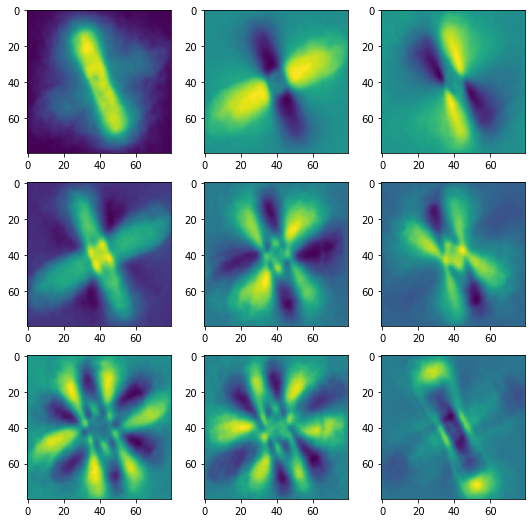

In [173]:
size = bnw[1,:,:].shape

fig, axs = plt.subplots(3, 3, figsize = [9, 9])

for i in np.arange(0,3):
    for j in np.arange(0,3):
        idx = i*3+j
        img = np.array(pcaMdl.components_[idx,:]).reshape(size)
        axs[i,j].imshow(img)
        
plt.show()

#S3:
Select all images, convert 3-channel (RGB) images to single-channel (Gray) (hint: scikit has the function "rgb2gray"). Flatten the images into a data matrix and apply PCA on them. Display the first 4 principal components as 2D images

- Q1: What is the total variance explained by the first 5 PCA components: **0.6086**
- Q2: How many PCA components are required to explain at least 50% of the variance: **just three components**
- Q3: Comment on the differences in variance explained in comparison to S2: 

**It is rather expected that images with and without ships would be more varied compared scenes capturing ships and only ships; likewise, fewer components explain more variation in the partial subset compared to the complete set. Also compelling is the nature of components when plotted: because ships—at least container ships—are all similar in shape, the only variation appears to be in the angle of that shape, so the plots end up looking like a clock in the first round. Perhaps the varation in the second round leads to blurred boundaries—though it is interesting that even in the larger sample, the contours of ships still pop out, suggesting that most distinctive aspect of all images in the presence or absence of a container ship.** 

In [0]:
mat = dat

scaler = StandardScaler()
scaler.fit(mat)
X = scaler.transform(mat)

In [175]:
pca = PCA(n_components = NUM_COMP)
pcaMdl = pca.fit(X)
pcaCoor = pcaMdl.transform(X)
dfPCA = pd.DataFrame(data = pcaCoor, columns = ['PCA_' + s for s in np.arange(0, NUM_COMP).astype(str)])

dfPCA.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22,PCA_23,PCA_24,PCA_25,PCA_26,PCA_27,PCA_28,PCA_29,PCA_30,PCA_31,PCA_32,PCA_33,PCA_34,PCA_35,PCA_36,PCA_37,PCA_38,PCA_39,PCA_40,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49,PCA_50,PCA_51,PCA_52,PCA_53,PCA_54,PCA_55,PCA_56,PCA_57,PCA_58,PCA_59,PCA_60,PCA_61,PCA_62,PCA_63,PCA_64,PCA_65,PCA_66,PCA_67,PCA_68,PCA_69,PCA_70,PCA_71,PCA_72,PCA_73,PCA_74,PCA_75,PCA_76,PCA_77,PCA_78,PCA_79
0,2.148901,30.585231,-6.872858,-17.615758,9.905715,28.423230,-1.891846,-23.514001,-5.355434,12.838623,4.713343,-4.512765,-3.671243,-4.969569,-0.392629,1.628276,12.850397,-0.354129,7.595724,-4.309162,-9.171652,-2.257050,-3.245801,1.901853,-0.934393,4.918164,-10.762445,-1.300413,1.358862,2.729688,-3.776565,0.473520,-6.506453,3.163703,1.248384,5.764847,0.407517,3.290747,1.847001,4.669526,-3.634505,1.426148,0.021732,-0.061702,2.317775,2.497585,2.547907,-4.887603,-1.162018,-4.390322,0.032389,1.344978,1.225096,2.952524,2.574107,-3.750239,-1.463192,-0.182208,-1.343964,-1.834707,-0.239151,-1.937564,-0.239085,-1.340222,1.154180,2.617212,0.575908,-0.428422,-0.615571,-3.633386,1.633477,-1.712250,2.055201,-2.982302,-0.585974,-1.366077,-2.142152,-0.916359,-0.897093,1.504379
1,-44.844173,-4.885748,7.011732,-8.592884,0.388665,9.426010,-14.106101,-1.422176,5.050704,6.357340,-0.800335,-4.316602,-4.801843,5.164651,3.294718,5.400480,10.409945,-0.039408,-4.179051,-2.791161,-2.320531,-3.832039,-1.885210,0.327021,-1.794154,0.315265,0.824438,-3.501601,-1.179716,-0.624547,-0.418310,-1.530651,-3.313259,5.038140,4.155669,-2.626613,2.284132,-0.360079,0.242023,0.669551,-0.980410,-1.568649,4.879090,-1.385249,-3.694470,-1.502601,3.861093,-3.008169,0.421785,-2.889198,2.210141,-3.126720,2.108178,1.541283,-0.952034,-2.211084,-2.929643,-0.986611,-1.057641,3.750158,-3.585484,0.143814,2.409437,-2.280705,-2.183680,-0.267726,0.246503,-1.955074,-1.155685,0.991422,0.838197,-0.144735,0.872968,-0.365688,-2.122030,-1.815329,0.663740,-0.851515,1.004714,0.134601
2,70.373457,-3.163573,1.826252,8.435343,2.244189,10.296961,0.157574,4.265899,3.703930,-4.148793,0.658921,-2.303873,8.220679,0.574567,-0.187030,-4.012185,1.277928,-4.489516,2.627794,1.885615,1.544819,-0.856274,-2.053244,1.904002,2.167300,-5.012395,-1.853600,-1.769677,2.793503,-0.681928,-0.791991,1.618801,-3.914762,-0.130863,-0.720781,2.767927,-1.602661,-2.571395,-3.253805,0.883132,-0.123878,1.521444,-1.314625,1.233137,0.682727,1.550022,-1.013738,-0.752865,-0.722134,-1.296731,0.252989,-1.517030,-1.832412,0.449637,3.308808,-0.229828,-1.666558,-0.820437,-0.218033,3.639513,2.474539,1.442014,-1.965475,2.682008,-1.931120,-3.141463,-2.613700,1.088653,-0.177098,1.467847,1.644839,0.769425,1.559424,0.614658,1.400370,-1.799796,0.826765,-1.441474,0.091988,-0.551245
3,7.693515,4.942821,-7.429404,-13.403251,1.715132,16.506608,2.447222,-15.303728,-5.964783,3.321235,4.024932,-2.417283,-0.993675,-6.011931,-2.056555,1.466566,4.618396,2.352576,11.700062,-2.481632,-2.613434,3.984337,3.473475,7.969604,-0.054607,-5.514692,0.657525,-0.792087,0.342038,5.841674,-4.358453,-4.695515,-0.226694,2.753823,-4.048852,1.966983,2.189746,0.792211,5.551647,3.421225,3.902208,3.944337,0.568651,-1.298296,-0.054581,-0.430893,0.964683,-0.824943,1.340976,1.311180,-1.124769,4.067060,-1.696890,-4.309868,-0.339511,-3.571350,1.473928,-1.290415,2.785657,0.370286,3.247722,-3.273442,0.846430,0.195138,1.974269,-3.336139,1.844183,0.785969,4.238861,1.341986,0.056230,-4.131729,-3.114820,1.065632,2.636627,-0.017324,-0.354989,0.641529,-1.879539,-0.285355
4,-0.099001,-1.200788,13.657038,26.789237,20.645788,15.035935,-3.540578,3.848846,3.319207,-13.422231,-1.633091,-7.561528,5.040490,0.003990,-0.625978,-2.405072,1.137052,-2.050505,8.079093,-3.657230,-1.702633,-4.301672,-1.204673,-0.566816,6.090847,-5.741001,0.368248,0.391384,-3.147116,-3.311842,1.082306,-1.572825,-2.205716,-2.842452,2.192295,-0.663831,-4.346341,-0.023112,-5.349294

In [176]:
print(np.sum(pcaMdl.explained_variance_ratio_[:4]))
print(np.sum(pcaMdl.explained_variance_ratio_[:2]))

0.6086453174840384
0.5484760419936537


In [177]:
print(np.sum(pcaMdl.explained_variance_ratio_))

0.8859430256017409


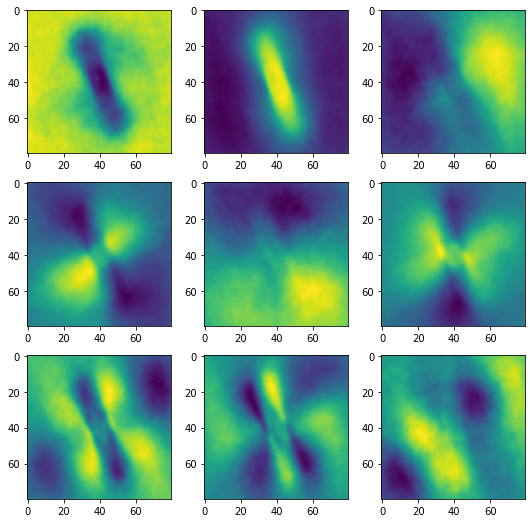

In [178]:
size = bnw[1,:,:].shape

fig, axs = plt.subplots(3, 3, figsize = [9, 9])

for i in np.arange(0,3):
    for j in np.arange(0,3):
        idx = i*3+j
        img = np.array(pcaMdl.components_[idx,:]).reshape(size)
        axs[i,j].imshow(img)
        
plt.show()

#S4:
Apply k-means clustering on all "ship" images for 4 clusters. Calculate the "mean" image for each cluster and display it.

- Q1: Comment on the clusters detected. Is there a common pattern for each cluster? Are the ships grouped based on orientation, image intensity differences, or something else?

**Hard to tell what each cluster is picking up on; plotting a random selection of each cluster below, I one cluster that appears to aggregated built environments. The rest of the clusters have ships in them, but some also include roads, piers, or other features of a landscape that look similar to ships. There are similarities in the angles, so many ships at one angle and then a road that cuts across in the same direction. One cluster appears to also have a bright reflection—one that occurs on both the metal of container ships but also other metal surfaces.**

In [0]:
from sklearn.cluster import KMeans

In [0]:
vals = KMeans(n_clusters = 4, random_state = 0).fit(pcaCoor)

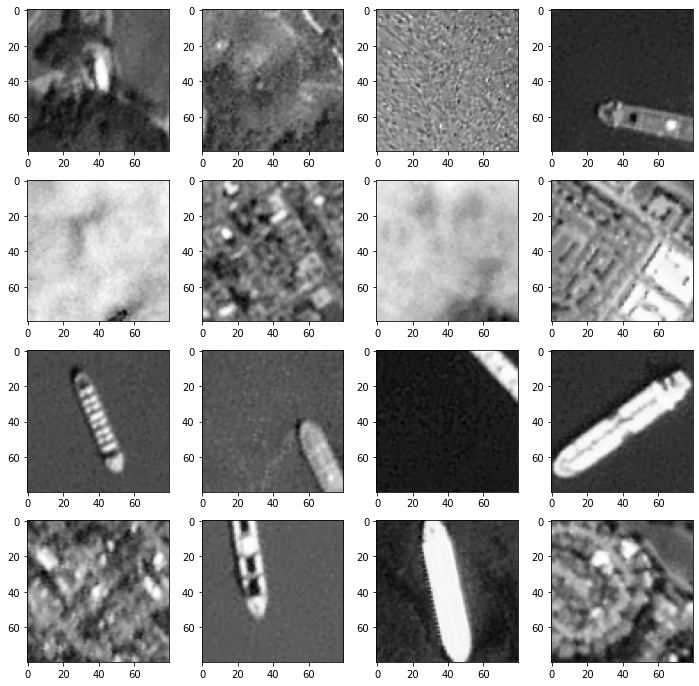

In [181]:
size = bnw[1,:,:].shape

fig, axs = plt.subplots(4, 4, figsize = [12, 12])

for i in np.arange(0, 4):
  sub = dat[vals.labels_ == i]
  for j in np.arange(0, 4):
    idx = np.random.randint(0, len(sub))
    img = sub[idx].reshape([80, 80])
    axs[i, j].imshow(img, cmap = 'gray')
        
plt.show()

#S5:
Apply k-means clustering on all images for 2 clusters.

- Q1: Calculate the "accuracy" of your clustering to discriminate ships from non-ship images. Show a two-by-two confusion matrix (to display the number/percentage of samples in clusters 1/2 and with labels 0/1)

**Conditional on which cluster we decide is classifying ships, the accuracy is either 46.375 or 53.625, so hardly better than chance in the best case.**

In [0]:
vals = KMeans(n_clusters = 2, random_state = 0).fit(pcaCoor)

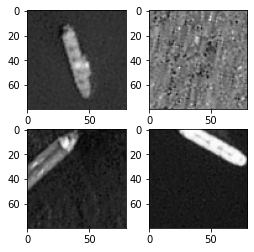

In [183]:
size = bnw[1,:,:].shape

fig, axs = plt.subplots(2, 2, figsize = [4, 4])

for i in np.arange(0, 2):
  sub = dat[vals.labels_ == i]
  for j in np.arange(0, 2):
    idx = np.random.randint(0, len(sub))
    img = sub[idx].reshape([80, 80])
    axs[i, j].imshow(img, cmap = 'gray')
        
plt.show()

In [0]:
from sklearn.metrics import confusion_matrix

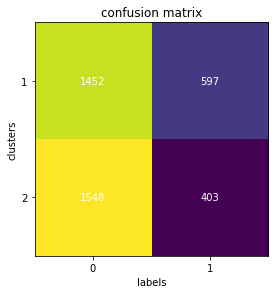

In [185]:
cm = confusion_matrix(vals.labels_, y)

fig, ax = plt.subplots()
im = ax.imshow(cm)

ax.set_xticks(np.arange(len(np.unique(vals.labels_))))
ax.set_yticks(np.arange(len(np.unique(y))))
ax.set_xticklabels(np.unique(vals.labels_))
ax.set_yticklabels(np.unique([1, 2]))

for i in range(len(np.unique(vals.labels_))):
    for j in range(len(np.unique(y))):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")

ax.set_title("confusion matrix")
fig.tight_layout()

plt.xlabel('labels')
plt.ylabel('clusters')
plt.show()

In [186]:
print('Accuracy: ' + str(100 * np.sum(vals.labels_ == y) / y.shape[0]))
print('Accuracy: ' + str(100 * np.sum(vals.labels_ != y) / y.shape[0]))

Accuracy: 46.375
Accuracy: 53.625


#S6:
Split the data into train and test sets (50/50 split). Train a linear SVM with default parameters. Apply it on the test dataset.

- Q1: What is the training accuracy? **90.4**
- Q2: What is the testing accuracy? **85.8**
- Q3: What is the AUC? **0.93**

In [0]:
indPos = np.where(y == 1)[0]
indNeg = shuffle(np.where(y == 0)[0], random_state = 42)[0:indPos.shape[0]]

indBal = shuffle(np.concatenate([indPos, indNeg]), random_state = 42)

XBal = pcaCoor[indBal, :]
YBal = y[indBal]

scaler = preprocessing.StandardScaler().fit(XBal)
XBalSc = scaler.transform(XBal)

X_train, X_test, y_train, y_test = train_test_split(XBalSc, YBal, stratify = YBal, train_size = 0.5, random_state = 42)

In [188]:
print('Train size: ' + str(y_train.shape[0]))
svc = SVC(kernel = 'linear')

print('Training the model ...')
svc.fit(X_train, y_train)

print('Applying the model ...')
yPred_1 = svc.predict(X_train)
yPred_2 = svc.predict(X_test)

print('Training accuracy: ' + str(100 * np.sum(yPred_1 == y_train) / y_train.shape[0]))
print('Testing accuracy: ' + str(100 * np.sum(yPred_2 == y_test) / y_test.shape[0]))

Train size: 1000
Training the model ...
Applying the model ...
Training accuracy: 90.4
Testing accuracy: 85.8


In [0]:
from scipy import interp

from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

from sklearn.model_selection import StratifiedKFold

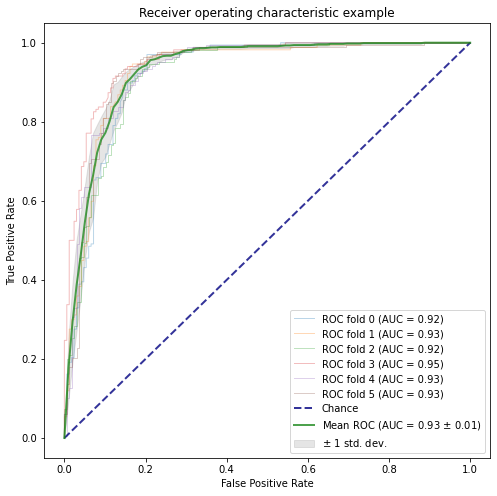

In [190]:
cv = StratifiedKFold(n_splits = 6)
classifier = SVC(kernel = 'linear', probability = True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

X = XBalSc
y = YBal

fig, ax = plt.subplots(figsize = [8, 8])
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='navy',
        label='Chance', alpha= 0.8)

mean_tpr = np.mean(tprs, axis = 0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color = 'forestgreen',
        label = r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw = 2, alpha = 0.8)

std_tpr = np.std(tprs, axis = 0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color = 'grey', alpha = 0.2,
                label = r'$\pm$ 1 std. dev.')

ax.set(xlim = [-0.05, 1.05], ylim = [-0.05, 1.05],
       title = "Receiver operating characteristic example")
ax.legend(loc = "lower right")
plt.show()

#S7:
Train "your best classifier". You can use parameter optimization, different classifiers, feature dimensionality reduction, or any other processing step for feature extraction on the data.

- Q1: What is the 10-fold testing accuracy of your classifier?